# Emotion Classification by Facial Expression Recognition.

## Importing Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from keras.optimizers import RMSprop, SGD


from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt

# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model

print('Required Libraries Imported')

## Importing Dataset

In [3]:

train_dir = '../input/emotion/train/'
test_dir = '../input/emotion/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


### PLot of number of images in training set

<AxesSubplot:>

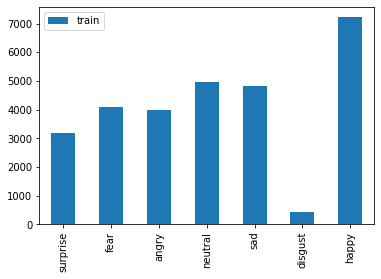

In [4]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

<AxesSubplot:>

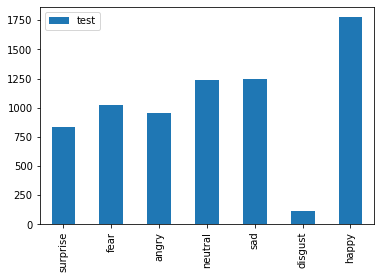

In [5]:
test_count.transpose().plot(kind='bar')

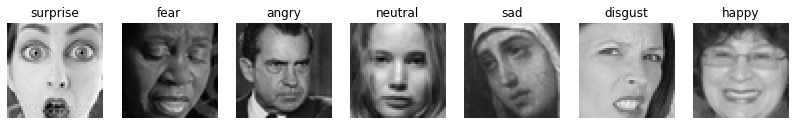

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [13]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


print('Get Model Function Defined')



Get Model Function Defined


In [14]:
fernet = get_model((row,col,1), classes)
fernet.summary()

print('Run complete')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 22, 256)      

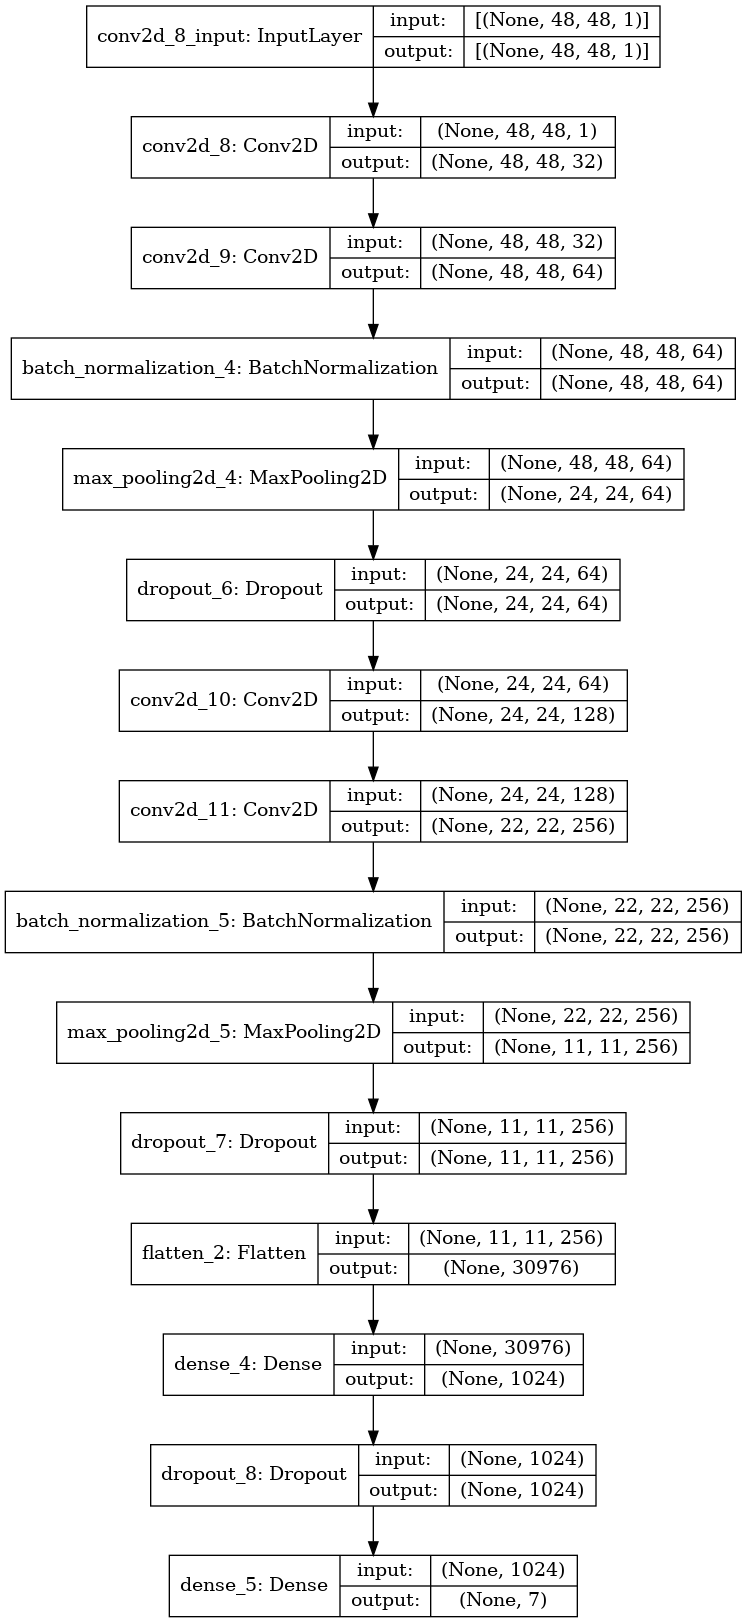

In [15]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [21]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

print('CallBack Functions Completed')



print('CallBack Functions Completed')

2022-09-26 16:31:10.827316: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-26 16:31:10.827383: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-26 16:31:10.911012: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-26 16:31:10.911211: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


CallBack Functions Completed
CallBack Functions Completed


## Training Model

In [22]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)


2022-09-26 16:31:15.111188: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-09-26 16:31:16.883280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


448/448 [==============================] - 114s 237ms/step - loss: 4.2883 - accuracy: 0.2744 - val_loss: 6.9826 - val_accuracy: 0.1883

Epoch 00001: val_loss improved from inf to 6.98257, saving model to ferNet.h5
Epoch 2/60
448/448 [==============================] - 42s 93ms/step - loss: 3.4839 - accuracy: 0.3342 - val_loss: 3.1200 - val_accuracy: 0.4028

Epoch 00002: val_loss improved from 6.98257 to 3.12004, saving model to ferNet.h5
Epoch 3/60
448/448 [==============================] - 40s 90ms/step - loss: 2.9693 - accuracy: 0.3688 - val_loss: 2.6472 - val_accuracy: 0.4247

Epoch 00003: val_loss improved from 3.12004 to 2.64723, saving model to ferNet.h5
Epoch 4/60
448/448 [==============================] - 40s 90ms/step - loss: 2.5660 - accuracy: 0.3946 - val_loss: 2.3154 - val_accuracy: 0.4455

Epoch 00004: val_loss improved from 2.64723 to 2.31536, saving model to ferNet.h5
Epoch 5/60
448/448 [==============================] - 40s 89ms/step - loss: 2.2477 - accuracy: 0.4281 - v

## Loss and Accuracy plot

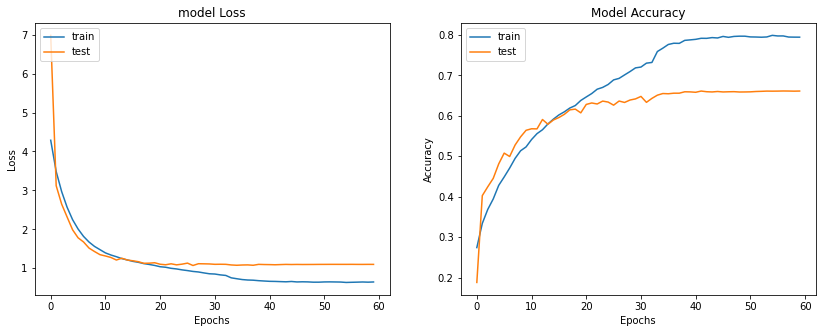

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

High accuracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset.

### Model evaluation

In [24]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 6s 53ms/step - loss: 1.0997 - accuracy: 0.6610
final train accuracy = 87.36 , validation accuracy = 66.10


In [26]:
fernet.save_weights('fernet_bestweight.h5')

print('Model Saved')

Model Saved


### Confusion Matrix and Classification on training set

Confusion Matrix
[[ 553   53  527  978  766  678  440]
 [  68    6   45  111   78   84   44]
 [ 571   58  523 1039  788  662  456]
 [ 983   88  874 1881 1343 1215  831]
 [ 639   66  670 1313  899  848  530]
 [ 656   55  621 1266  871  809  552]
 [ 430   46  422  824  557  561  331]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.02      0.01      0.01       436
        fear       0.14      0.13      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.10      0.10      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



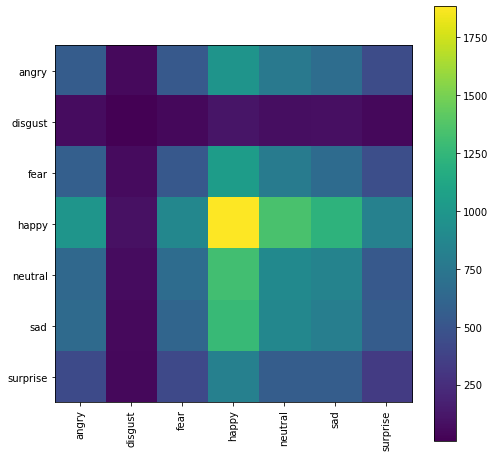

In [27]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

Confusion Matrix
[[130   9 119 236 201 152 111]
 [ 19   2  17  24  21  13  15]
 [138   7 121 281 204 158 115]
 [254  24 203 431 354 291 217]
 [157  13 151 288 247 237 140]
 [174   4 139 335 244 206 145]
 [122   8  89 209 161 147  95]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       958
     disgust       0.03      0.02      0.02       111
        fear       0.14      0.12      0.13      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.20      0.19      1233
         sad       0.17      0.17      0.17      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



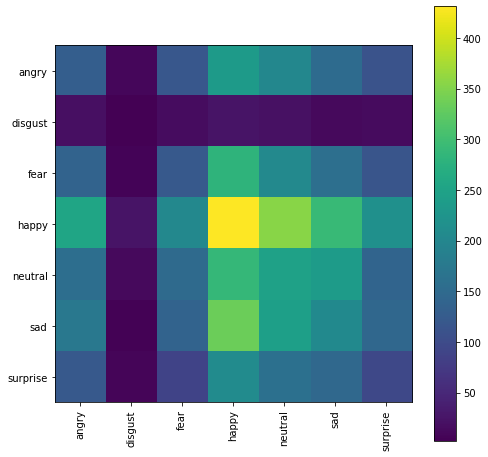

In [28]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [29]:
print('Training/Testing Complete')

Training/Testing Complete
